In [ ]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 15.2 MB/s eta 0:00:00


In [ ]:
!pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=471389 sha256=e322b7843273a2abbd8b0fc2773e5c0a939d155ebc4d1128c35b71963bef9550
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import cat, no_grad, manual_seed
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout,
    CrossEntropyLoss,
    Flatten,
    Sequential,
    ReLU,
)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal, CXGate
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Loading the Fashion MNIST dataset

In [ ]:
# Convert the images into normalized Tensors

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,),)])

# Load the train/test datasets

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform = transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform = transform)

# Create Validation set

train_indices = list(range(1000))
test_indices = list(range(500))
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)
train_sample = SubsetRandomSampler(train_indices)
test_sample =  SubsetRandomSampler(test_indices)

# Data Loader

train_loader = DataLoader(trainset, sampler = train_sample, batch_size = 64)
#valid_loader  = DataLoader(trainset, sampler = valid_sample, batch_size = 32)
test_loader  = DataLoader(testset, sampler = test_sample, batch_size = 64)

100%|██████████| 26421880/26421880 [00:01<00:00, 15983431.93it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273582.27it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5027398.09it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19992849.07it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
print(f'Train size: {len(train_sample)} | Test size: {len(test_sample)}')

Train size: 1000 | Test size: 500


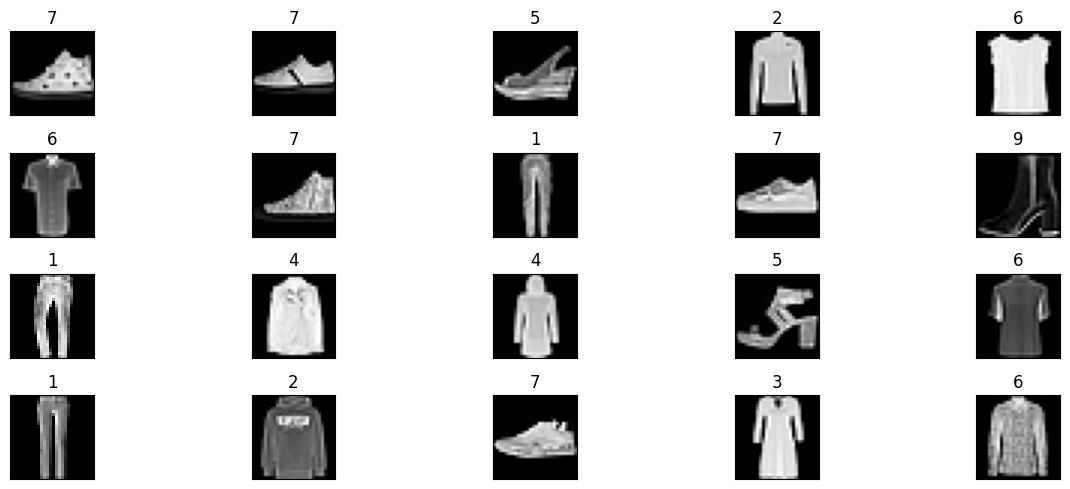

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

# Creating QSAN module

In [ ]:
# initialize qc architecture params
num_qubits = 3
Denc = 1

In [ ]:
class Feature_map():

  '''
  Creates the parametric quantum encoding module
  '''

  def __init__(self, num_qubits, Denc):
    self.num_qubits = num_qubits
    self.Denc = Denc

  def parameters(self):
    params = ParameterVector("input", self.num_qubits*(self.Denc+2))
    return params

  def fmap(self):
    indx=0
    params = self.parameters()
    qc = QuantumCircuit(self.num_qubits)
    for j in range(self.num_qubits):
        qc.rx(params[indx],j)
        qc.ry(params[indx+1],j)
        indx+=2
    for i in range(self.Denc):
        for j in range(self.num_qubits):
            qc.cx(j,(j+1)%self.num_qubits)

        for j in range(self.num_qubits):
            #qc.rx(params[indx],j)
            qc.ry(params[indx],j)
            indx+=1
    return qc

In [ ]:
f = Feature_map(num_qubits, Denc)
circ = f.fmap()
circ.draw()

┌──────────────┐┌──────────────┐          ┌───┐┌──────────────┐
q_0: ┤ Rx(input[0]) ├┤ Ry(input[1]) ├──■───────┤ X ├┤ Ry(input[6]) ├
     ├──────────────┤├──────────────┤┌─┴─┐     └─┬─┘├──────────────┤
q_1: ┤ Rx(input[2]) ├┤ Ry(input[3]) ├┤ X ├──■────┼──┤ Ry(input[7]) ├
     ├──────────────┤├──────────────┤└───┘┌─┴─┐  │  ├──────────────┤
q_2: ┤ Rx(input[4]) ├┤ Ry(input[5]) ├─────┤ X ├──■──┤ Ry(input[8]) ├
     └──────────────┘└──────────────┘     └───┘     └──────────────┘

In [ ]:
class Ansatz():

  '''
  Creates the QSAN ansatz and returns the circuit along with its tunable parameters
  '''

  def __init__(self,num_qubits):
    self.num_qubits = num_qubits

  def parameterized_circuit(self, circuit, num_qubits, repitions, name):
    parameter_prefix = str(name)
    params = ParameterVector(parameter_prefix, num_qubits)
    qc = QuantumCircuit(self.num_qubits)
    for r in range(repitions):
      qc.h(range(self.num_qubits))
      for i in range(self.num_qubits):
        qc.ry(params[i],i)
    '''for i in range(self.num_qubits-1):
      qc.cx(i,i+1)'''
    qc.barrier()
    circuit.compose(qc, inplace=True)
    return circuit

  def qsal_layer(self):
    input_reg = QuantumRegister(self.num_qubits, 'input')
    gar_q_reg = QuantumRegister(self.num_qubits, 'q')
    gar_k_reg = QuantumRegister(self.num_qubits, 'k')
    qls_reg = QuantumRegister(self.num_qubits, 'qls')
    measure_reg = ClassicalRegister(3, 'measure')
    circuit = QuantumCircuit(input_reg, gar_q_reg, gar_k_reg, qls_reg, measure_reg)

    #input_data(circuit)
    self.parameterized_circuit(circuit, self.num_qubits, 1, 'q')
    circuit.barrier()

    #barbell
    for k in range (self.num_qubits):
        circuit.swap(input_reg[k], gar_q_reg[k])
    circuit.barrier()
    self.parameterized_circuit(circuit, self.num_qubits, 1, 'k')
    circuit.barrier()

    #barbell
    for k in range (self.num_qubits):
        circuit.swap(input_reg[k], gar_k_reg[k])
    circuit.barrier()

    #qls_module
    for k in range(self.num_qubits):
        circuit.ccx(gar_q_reg[k], gar_k_reg[k], qls_reg[k])
    circuit.barrier()
    for k in range(self.num_qubits-1):
        circuit.cx(qls_reg[k], qls_reg[k+1])
    circuit.barrier()
    self.parameterized_circuit(circuit, self.num_qubits, 1, 'v')
    circuit.barrier()

    #compression
    '''for k in range(self.num_qubits-1):
        circuit.cx(input_reg[k], input_reg[k+1])'''

    #slicing
    for k in range(self.num_qubits):
        circuit.reset(gar_q_reg[k])
    for k in range(self.num_qubits):
        circuit.cx(qls_reg[k], gar_q_reg[k])
        return circuit

  def parameters(self):
    circuit = self.qsal_layer()
    return circuit.parameters

In [ ]:
def create_observables(num_qubits,*index_dicts):
  '''
  Create your custom observables
  num_qubits: # input qubits (int)
  index_dicts: dictionaries containing values as Pauli Operators and keys as indices locating the circuit line to apply the pauli operator
  '''
  observables=[]
  num_obs = len(index_dicts)
  pauli_str = "I"*num_qubits*4
  for index_dict in index_dicts:
    obs = list(pauli_str)
    for index in index_dict.keys():
      obs[index] = index_dict[index]
    observables.append(SparsePauliOp.from_list([("".join(obs),1)]))
  return observables

In [ ]:
create_observables(num_qubits, {2:'Z',3:'Z',4:'Z',5:'Z'})

[SparsePauliOp(['IIZZZZIIIIII'],
               coeffs=[1.+0.j])]

In [ ]:
def create_qnn(num_qubits, Denc):

    # create instances of class Feature_map and Ansatz for further usage
    feature_map = Feature_map(num_qubits, Denc)
    ansatz = Ansatz(num_qubits)
    # create your custom observable(s) by passing dictionaries
    observables = create_observables(num_qubits, {2:'Z',3:'Z',4:'Z',5:'Z'}, {2:'X',3:'X',4:'X',5:'X'})
    # initialize the total quantum circuit
    input_reg = QuantumRegister(num_qubits, 'input')
    gar_q_reg = QuantumRegister(num_qubits, 'q')
    gar_k_reg = QuantumRegister(num_qubits, 'k')
    qls_reg = QuantumRegister(num_qubits, 'qls')
    qc = QuantumCircuit(input_reg, gar_q_reg, gar_k_reg, qls_reg)
    # create the quantum encoder circuit from feature map created above
    sub_circ = QuantumCircuit(num_qubits, name='quantum encoder')
    sub_circ.compose(feature_map.fmap(), inplace=True)
    # apply the same encoder to input registers, garbage q registers and garbage k registers
    qc.append(sub_circ.to_instruction(), [input_reg[i] for i in range(num_qubits)])
    qc.append(sub_circ.to_instruction(), [gar_q_reg[i] for i in range(num_qubits)])
    qc.append(sub_circ.to_instruction(), [gar_k_reg[i] for i in range(num_qubits)])
    input_params = qc.parameters
    # finally add the QSAN ansatz
    qc.compose(ansatz.qsal_layer(), inplace=True)
    # create the estimator primitive of the above quantum circuit using EstimatorQNN and set it to training mode
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observables,
        input_params=input_params,
        weight_params=ansatz.parameters(),
        input_gradients=True,
    )
    return qnn

qnn = create_qnn(num_qubits, Denc)

In [ ]:
class QImageNet(Module):
    def __init__(self, qnn, num_qubits, Denc):
        super().__init__()
        self.num_qubits = num_qubits
        self.Denc = Denc
        self.fc1 = Linear(784, 256)
        self.dropout = Dropout(p=0.3)
        self.fc2 = Linear(256,64)
        self.dropout = Dropout(p=0.4)
        self.fc3 = Linear(64, self.num_qubits*(self.Denc+2))   # num_qubits*(Denc+2)-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen uniformly at random from interval [-1,1].
        self.fc4 = Linear(2, 10)  # 2-dim input as there are 2 observables, 10-dimensional output from QNN

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.tanh(x) * np.pi / 2.0
        q_out = torch.Tensor(0, 2)
        q_out = q_out.to(device)
        for elem in x:
            q_out_elem = self.qnn(elem).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.fc4(q_out)


model = QImageNet(qnn,num_qubits, Denc).to(device)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Define model, optimizer, and loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 20  # Set number of epochs
train_loss_list = []  # Store loss history
test_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(epochs):

    model.train()  # Set model to training mode
    train_loss = []
    train_acc = []
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)
        optimizer.zero_grad(set_to_none=True)                               # Initialize gradient
        train_logits = model(X_train_batch)                                 # Forward pass
        train_pred = train_logits.argmax(dim=1)
        loss = loss_func(train_logits, y_train_batch)                       # Calculate loss
        acc = accuracy_fn(y_true=y_train_batch,
                                y_pred=train_pred)
        loss.backward()                                                     # Backward pass
        optimizer.step()                                                    # Optimize weights
        train_loss.append(loss.item())                                      # Store loss
        train_acc.append(acc)
    train_loss_list.append(sum(train_loss) / len(train_loss))
    train_acc_list.append(sum(train_acc)/len(train_acc))

    model.eval()
    test_loss = []
    test_acc = []
    for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)
        with torch.inference_mode():
          # 1. Forward pass
          test_logits = model(X_test_batch)
          test_pred = test_logits.argmax(dim=1)
          # 2. Calculate test loss and accuracy
          loss = loss_func(test_logits, y_test_batch)
          acc = accuracy_fn(y_true=y_test_batch,
                                y_pred=test_pred)
          test_loss.append(loss)
          test_acc.append(acc)
    test_loss_list.append(sum(test_loss) / len(test_loss))
    test_acc_list.append(sum(test_acc)/len(test_acc))
    print(f"Epoch: {epoch+1} |Train Loss: {train_loss_list[-1]} | Train Accuracy: {train_acc_list[-1]} | Test Loss: {test_loss_list[-1]} | Test Accuracy: {test_acc_list[-1]}")

Epoch: 1 |Train Loss: 2.4133310317993164 | Train Accuracy: 11.640625 | Test Loss: 2.381824016571045 | Test Accuracy: 9.585336538461538
Epoch: 2 |Train Loss: 2.4108062237501144 | Train Accuracy: 11.58203125 | Test Loss: 2.380723476409912 | Test Accuracy: 9.359975961538462


KeyboardInterrupt: ignored